In [1]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
from __future__ import print_function
np.random.seed(1)
import pandas as pd

import neighbourhood_effect
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Reading data

In [2]:
feature_names = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status","Occupation", 
                 "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week", "Country"]

data = np.genfromtxt('data/adult.data', delimiter=', ', dtype=str)

Encoding categorical variables and saving the encoders

In [3]:
labels = data[:,14]

le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data[:,:-1]

categorical_features = [1,3,5, 6,7,8,9,13]

# data_original = data.copy()

# Dictionary with keys as categorical feature column number and values as classes in the categories
categorical_names = {}
# Dictionary with keys as categorical feature column number and values as encoder for that categorical variable
categorical_names_encoder = {}

for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data[:, feature])
    data[:, feature] = le.transform(data[:, feature])
    categorical_names[feature] = le.classes_
    categorical_names_encoder[feature] = le

# This is a function which uses an encoder to encode a category and returns encoded value
def encode_fn (encoder, category):
    return encoder.transform([category])[0]

data = data.astype(float)

np.random.seed(1)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80)

/home/kanishka/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Building a Machine Learning model

In [4]:
# Training ML model
from sklearn.ensemble import RandomForestClassifier
rftree = RandomForestClassifier(n_estimators=300, max_depth=5)
rftree.fit(train, labels_train)

# Creating a predict function.
# This function takes a data row as input and outputs class probabilities in case of a classifier
predict_fn = lambda x: rftree.predict_proba(x).astype(float)[0]

In [5]:
i = 300
train_data = train
data_row = train[i].reshape(1, -1)
columns=list(range(14))
step_size_list = [0.05, 0.1, 0.5, 1, 5, 10, 50]
class_label=1
no_of_points=5

output = neighbourhood_effect.variable_impact_in_neighbourhood(train_data=train_data, data_row=data_row[0],
                                columns=columns,predict_fn=predict_fn,
                                 categorical_names_encoder = categorical_names_encoder, encode_fn=encode_fn,
                                 categorical_names = categorical_names,
                                 categorical_features = categorical_features,
                                 feature_names=feature_names, step_size_list = step_size_list,
                                 class_label=class_label, no_of_points=no_of_points)

output

{'Age': ([38.0, 36.0, 35.0, 31.0, 30.0, 40.0, 76.0, 90.0],
  [0.39805809168286926,
   0.3974262246159343,
   0.37075493443819896,
   0.34800149161297195,
   0.3413215509641262,
   0.39897065543946025,
   0.39577996871307697,
   0.39577996871307697],
  [0, 0, 0, 0, 0, 1, 0, 0]),
 'Capital Gain': ([0.0, 114.0, 401.0, 3818.0, 4386.0, 4865.0],
  [0.39897065543946025,
   0.36541120685562473,
   0.36506644284382528,
   0.3706608417399484,
   0.37448068561215553,
   0.43527960980852737],
  [1, 0, 0, 0, 0, 0]),
 'Capital Loss': ([0.0, 213.0, 810.0, 2001.0, 2057.0, 2163.0],
  [0.39897065543946025,
   0.43527960980852737,
   0.43291211864244966,
   0.48293283859678193,
   0.47779394970789318,
   0.48068703146889941],
  [1, 0, 0, 0, 0, 0]),
 'Country': (['?',
   'Cambodia',
   'Canada',
   'China',
   'Columbia',
   'Cuba',
   'Dominican-Republic',
   'Ecuador',
   'El-Salvador',
   'England',
   'France',
   'Germany',
   'Greece',
   'Guatemala',
   'Haiti',
   'Holand-Netherlands',
   'Hondura

# Neighbourhood Plot for a Variable

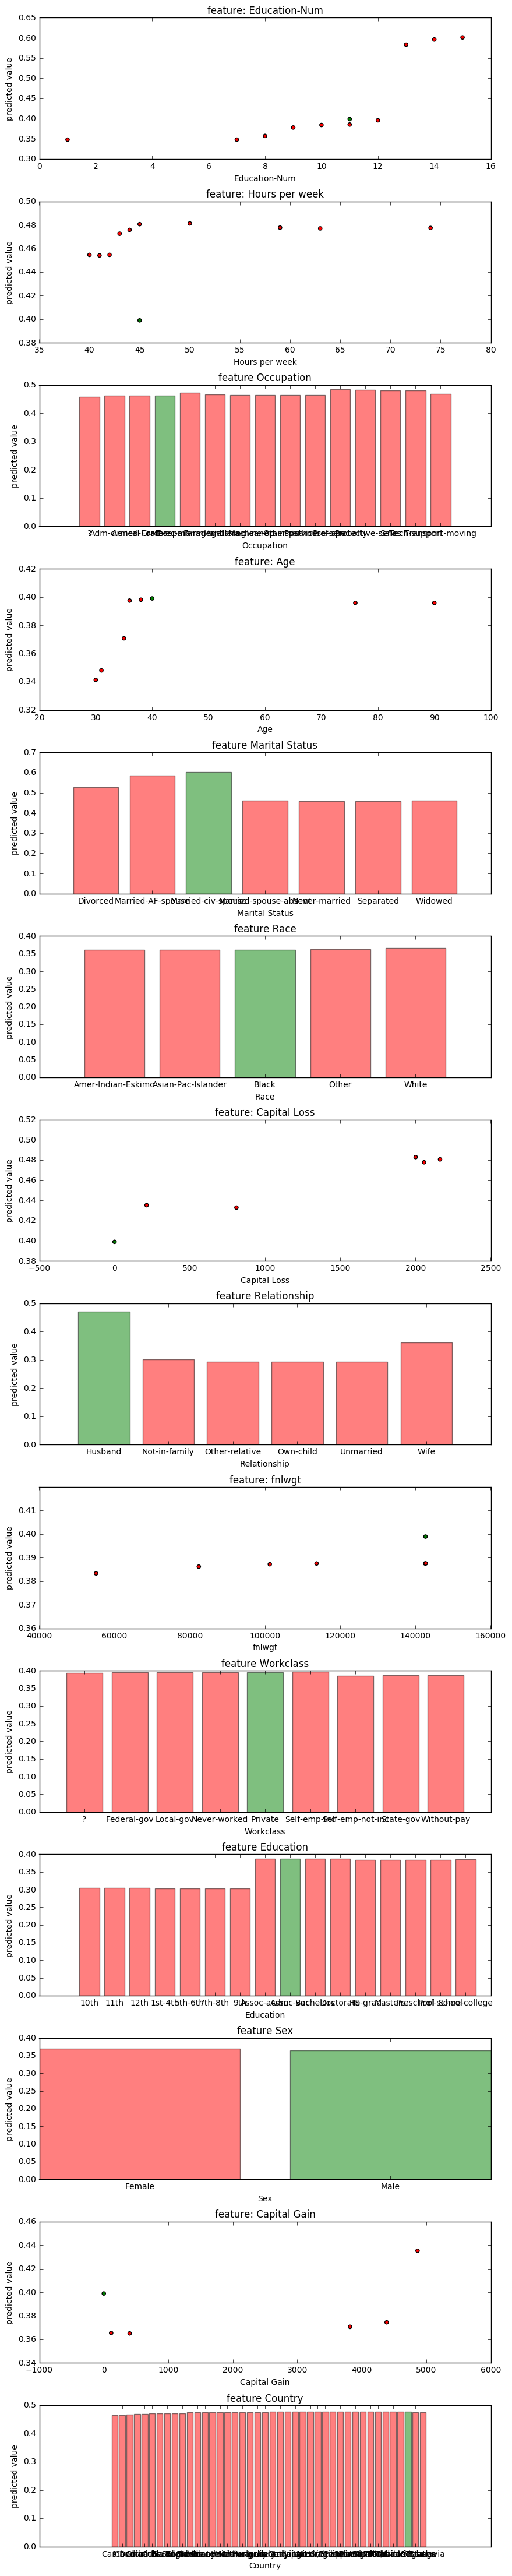

In [33]:
import matplotlib.pyplot as plt
import matplotlib

# Categorical features' names for marking x-axis of the plot
if len(feature_names) != 0:
    categorical_feature_names = [feature_names[column_no] for column_no in categorical_features]
else:
    categorical_feature_names = categorical_features

# columns_to_plot = [feature_names[0]]
columns_to_plot = output.keys()
no_of_columns = len(columns_to_plot)

plt.figure(figsize=(10,4*no_of_columns))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.3)
plot_no = 1
for key in columns_to_plot:
    
    if key not in categorical_feature_names:
        
        plt.subplot(no_of_columns,1,plot_no)

        y = output[key][1]
        x = output[key][0]
        labels = output[key][2]
        colors = ['red','green']
        plt.xlabel(key, fontsize=10)
        plt.ylabel('predicted value')

        plt.scatter(x, y, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
        plt.title('feature: '+str(key))
    else:
        plt.subplot(no_of_columns,1,plot_no)

        
        objects = output[key][0]
        y_pos = np.arange(len(objects))
        y = output[key][1]
        labels = output[key][2]
        colors = ['red' if label == 0 else 'green' for label in labels]
        plt.xlabel(key, fontsize=10)
        plt.ylabel('predicted value')

        plt.bar(y_pos, y, align='center', alpha=0.5, color=colors)
        plt.xticks(y_pos, objects)
        plt.title('feature '+str(key))
    
    plot_no+=1

plt.show()